Generating images and their corresponding binary masks from CReSIS (Center for Remote Sensing of Ice Sheets) data files for semantic segmentation.

Download Matlab files from https://data.cresis.ku.edu/data/rds/

In [12]:
import os
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import math
import cv2

In [13]:
# Reading CReSIS .mat files
inputfilename ='./CReSIS_Original/Data_20110329_01_033.mat'
mat = scipy.io.loadmat(inputfilename)
for variable_name in mat:
    if not variable_name.startswith('__'): 
        variable = mat[variable_name]
        shape = np.shape(variable)
        print(f"Variable: {variable_name}\tShape: {shape}")

Variable: array_param	Shape: (1, 1)
Variable: param_combine_wf_chan	Shape: (1, 1)
Variable: Latitude	Shape: (1, 3003)
Variable: Longitude	Shape: (1, 3003)
Variable: Elevation	Shape: (1, 3003)
Variable: GPS_time	Shape: (1, 3003)
Variable: Data	Shape: (1839, 3003)
Variable: Time	Shape: (1, 1839)
Variable: Depth	Shape: (1, 1839)
Variable: param_records	Shape: (1, 1)
Variable: param_csarp	Shape: (1, 1)
Variable: param_radar	Shape: (1, 1)
Variable: Surface	Shape: (1, 3003)
Variable: Bottom	Shape: (1, 3003)


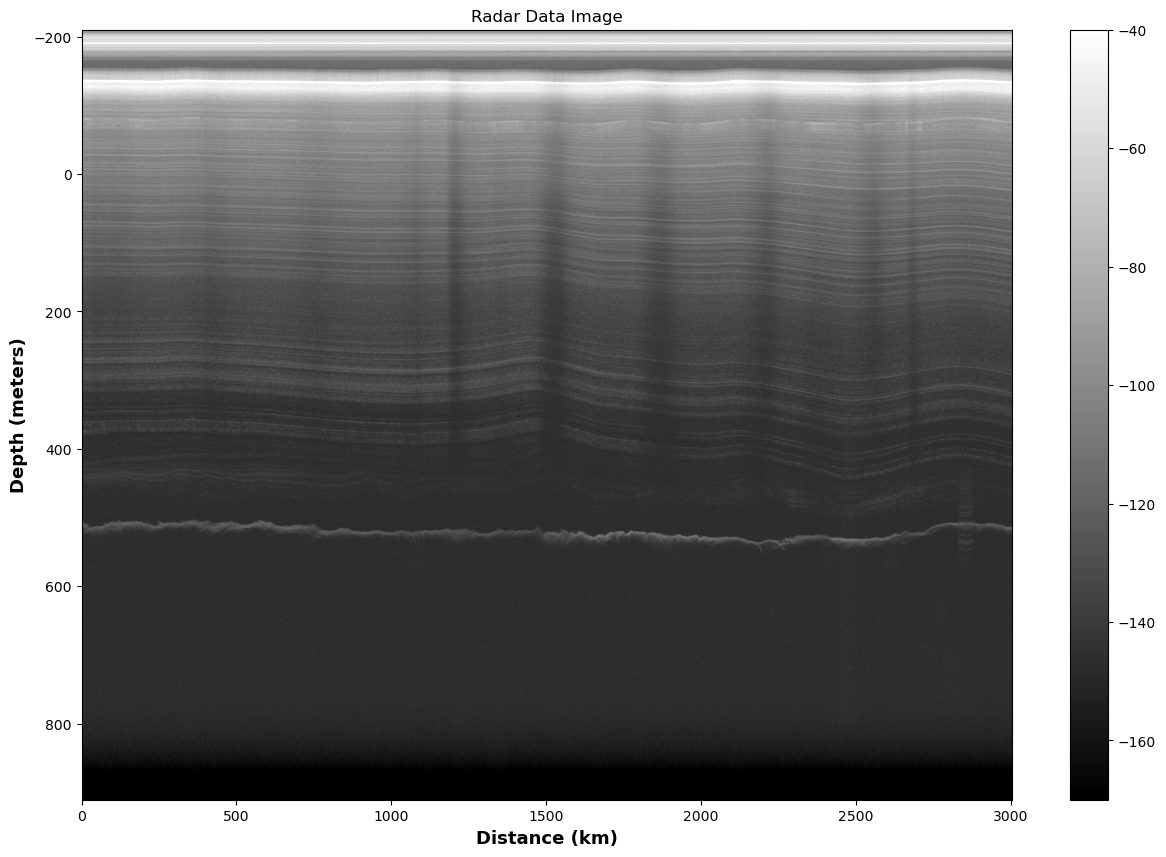

True

In [8]:
# Plot a sample MATLAB file and save it as an image

# Load the MATLAB file
cresis = sio.loadmat('./CReSIS_Original/Data_20110329_01_033.mat', struct_as_record=False, squeeze_me=True)

# Constants for speed of light and refractive index of ice
c = 3e8  # Speed of light
n_ice = math.sqrt(3.17)  # Refractive index for ice

# Calculate the depth 'd' from the radar time 'Time'
d = 0.5 * (cresis["Time"] - cresis["Time"][75]) * (c / n_ice)

# Calculate the box extents for the plot
box = np.array([0, cresis["Data"].shape[1], d[400], d[0]])

# Plotting the radar data
fig, ax = plt.subplots(figsize=(15, 10))
cresis_im = ax.imshow(10 * np.log10(cresis["Data"]), cmap='gray', aspect='auto', vmin=-170, vmax=-40, extent=box)
ax.set_xlabel('Distance (km)', fontsize=13, fontweight='bold')
ax.set_ylabel('Depth (meters)', fontsize=13, fontweight='bold')
fig.colorbar(cresis_im, ax=ax)
plt.title('Radar Data Image')
plt.savefig('radar_data_image.png')
plt.show()

# First, convert the radar data to a grayscale image
radar_image_gray = cv2.normalize(cresis["Data"], None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)

# Resize the grayscale image to the desired dimensions (1024x1408)
resized_radar_image_gray = cv2.resize(radar_image_gray, (1408, 1024), interpolation=cv2.INTER_LINEAR)

# Convert the single-channel grayscale image to a 3-channel grayscale image
resized_radar_image_gray_3ch = cv2.cvtColor(resized_radar_image_gray, cv2.COLOR_GRAY2BGR)

# Save the radar data image
cv2.imwrite('resized_radar_data_image.png', resized_radar_image_gray_3ch)


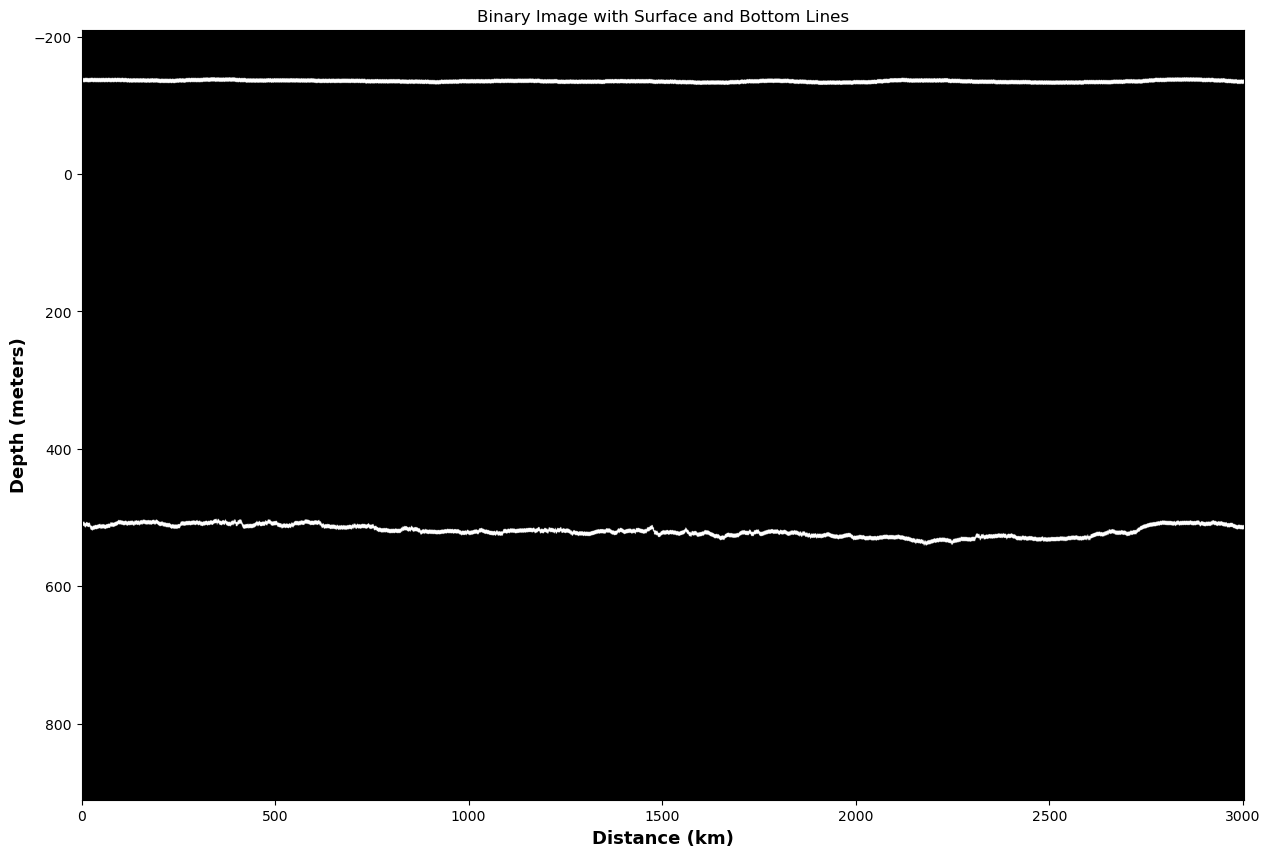

True

In [9]:
# Extract surface and bottom two-way travel times
surface_twtt = cresis['Surface'].flatten()
bottom_twtt = cresis['Bottom'].flatten()

# Convert TWTT to depth indices for surface and bottom
surface_indices = np.interp(surface_twtt, cresis["Time"], np.arange(len(d)))
bottom_indices = np.interp(bottom_twtt, cresis["Time"], np.arange(len(d)))

# Create a black image
binary_image = np.zeros(cresis["Data"].shape, dtype=np.uint8)

# Line thickness
thickness = 10

# Plot the surface and bottom as thicker white lines
for col in range(binary_image.shape[1]):
    surface_idx = int(surface_indices[col]) if not np.isnan(surface_indices[col]) else -1
    bottom_idx = int(bottom_indices[col]) if not np.isnan(bottom_indices[col]) else -1
    if 0 <= surface_idx < binary_image.shape[0]:
        binary_image[max(0, surface_idx - thickness // 2):min(binary_image.shape[0], surface_idx + thickness // 2), col] = 255
    if 0 <= bottom_idx < binary_image.shape[0]:
        binary_image[max(0, bottom_idx - thickness // 2):min(binary_image.shape[0], bottom_idx + thickness // 2), col] = 255

# Plotting the binary image
fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(binary_image, cmap='gray', aspect='auto', extent=box)
ax.set_xlabel('Distance (km)', fontsize=13, fontweight='bold')
ax.set_ylabel('Depth (meters)', fontsize=13, fontweight='bold')
plt.title('Binary Image with Surface and Bottom Lines')
plt.savefig('binary_surface_bottom_image.png')
plt.show()

#fig, ax = plt.subplots(figsize=(15, 10))
#ax.imshow(binary_image, cmap='gray', aspect='auto')
#ax.axis('off')  # Turn off the axis

# Save the figure without borders or axes
#plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
#plt.savefig('binary_surface_bottom_image.png', bbox_inches='tight', pad_inches=0)
#plt.close()

# Resize the binary image to the desired dimensions (1024x1408)
resized_binary_image = cv2.resize(binary_image, (1408, 1024), interpolation=cv2.INTER_NEAREST)
if len(binary_image.shape) == 3 and binary_image.shape[2] == 3:
    binary_image = cv2.cvtColor(binary_image, cv2.COLOR_BGR2GRAY)

# Resize the binary image to the desired dimensions (1408x1024)
resized_binary_image = cv2.resize(binary_image, (1408, 1024), interpolation=cv2.INTER_NEAREST)

# Save the binary image without borders or axes
cv2.imwrite('resized_binary_surface_bottom_image.png', resized_binary_image)

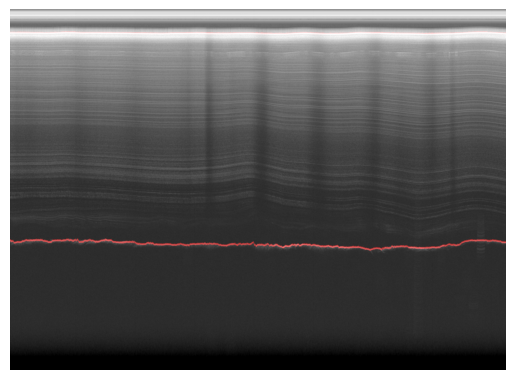

True

In [11]:
# Sanity checks to see whether they overlays 

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the images
radar_image = cv2.imread('radar_data_image_1408x1024.png')
binary_image = cv2.imread('resized_binary_image_1408x1024.png', cv2.IMREAD_GRAYSCALE)

# Convert the binary image to a color image (still binary)
binary_color_image = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2BGR)
binary_color_image[binary_image == 255] = [0, 0, 255]  # Red color

# Define transparency factor (between 0 and 1)
alpha = 0.5

# Blend the images
overlay_image = cv2.addWeighted(radar_image, 1, binary_color_image, alpha, 0)

# Convert BGR to RGB for Matplotlib
overlay_image = cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB)

# Show the result using Matplotlib
plt.imshow(overlay_image)
plt.axis('off')  # Turn off the axis numbers and labels
plt.show()

# Optionally, save the overlay image
cv2.imwrite('overlay_image.png', overlay_image)



In [14]:
# Generating images with the dimension of (1408,1024,3) for all downloaded Matlab files

# Source and target directories
source_dir =  './CReSIS_Original/'
target_dir =  './CReSIS_Images/'

# Ensure target directory exists
if not os.path.exists(target_dir):
    os.makedirs(target_dir)

# Constants for speed of light and refractive index of ice
c = 3e8  # Speed of light
n_ice = math.sqrt(3.17)  # Refractive index for ice

# Set DPI for output images
dpi = 100

for file in os.listdir(source_dir):
    if file.endswith('.mat'):
        # Load the MATLAB file
        file_path = os.path.join(source_dir, file)
        cresis = sio.loadmat(file_path, struct_as_record=False, squeeze_me=True)

        # Calculate the depth 'd' from the radar time 'Time'
        d = 0.5 * (cresis["Time"] - cresis["Time"][75]) * (c / n_ice)

        # Calculate the box extents for the plot
        box = np.array([0, cresis["Data"].shape[1], d[400], d[0]])

        # Create figure with the specified size
        fig_width, fig_height = 1408 / dpi, 1024 / dpi  # Convert target size to inches
        fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=dpi)
        cresis_im = ax.imshow(10 * np.log10(cresis["Data"]), cmap='gray', aspect='auto', vmin=-170, vmax=-40, extent=box)
        
        # Remove axes and padding
        ax.axis('off')
        plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

        # Save the figure with the same name in the target directory
        output_filename = os.path.splitext(file)[0] + '.png'  # Change extension to .png
        output_path = os.path.join(target_dir, output_filename)
        plt.savefig(output_path, bbox_inches='tight', pad_inches=0, dpi=dpi)
        plt.close(fig)


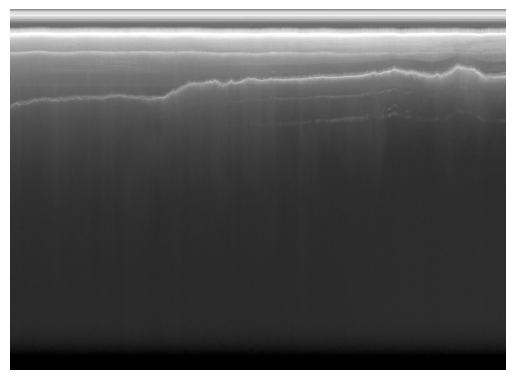

In [20]:
# plot a sample generated image
radar_image = cv2.imread( './CReSIS_Images/Data_20110329_01_011.png')
import cv2
import matplotlib.pyplot as plt
plt.imshow(radar_image)
plt.axis('off')
plt.show()


In [15]:
# Generating binar mask with the dimension of (1408,1024,3) for all downloaded Matlab files

# Source and target directories
source_dir = './CReSIS_Original/'
target_dir = './CReSIS_Binary/'

# Constants for speed of light and refractive index of ice
c = 3e8  # Speed of light
n_ice = math.sqrt(3.17)  # Refractive index for ice

# Ensure the target directory exists
if not os.path.exists(target_dir):
    os.makedirs(target_dir)

# Process each file in the source directory
for filename in os.listdir(source_dir):
    if filename.endswith('.mat'):
        file_path = os.path.join(source_dir, filename)
        cresis = sio.loadmat(file_path, struct_as_record=False, squeeze_me=True)

        # Calculate the depth 'd' from the radar time 'Time'
        d = 0.5 * (cresis["Time"] - cresis["Time"][75]) * (c / n_ice)

        # Extract surface and bottom two-way travel times
        surface_twtt = cresis['Surface'].flatten()
        bottom_twtt = cresis['Bottom'].flatten()

        # Convert TWTT to depth indices
        surface_indices = np.interp(surface_twtt, cresis["Time"], np.arange(len(d)))
        bottom_indices = np.interp(bottom_twtt, cresis["Time"], np.arange(len(d)))

        # Create and populate the binary image
        binary_image = np.zeros(cresis["Data"].shape, dtype=np.uint8)
        thickness = 10
        for col in range(binary_image.shape[1]):
            surface_idx = int(surface_indices[col]) if not np.isnan(surface_indices[col]) else -1
            bottom_idx = int(bottom_indices[col]) if not np.isnan(bottom_indices[col]) else -1
            if 0 <= surface_idx < binary_image.shape[0]:
                binary_image[max(0, surface_idx - thickness // 2):min(binary_image.shape[0], surface_idx + thickness // 2), col] = 255
            if 0 <= bottom_idx < binary_image.shape[0]:
                binary_image[max(0, bottom_idx - thickness // 2):min(binary_image.shape[0], bottom_idx + thickness // 2), col] = 255

        # Resize the binary image
        resized_binary_image = cv2.resize(binary_image, (1408, 1024), interpolation=cv2.INTER_NEAREST)

        # Save the binary image
        output_filename = os.path.splitext(filename)[0] + '.png'
        output_path = os.path.join(target_dir, output_filename)
        cv2.imwrite(output_path, resized_binary_image)

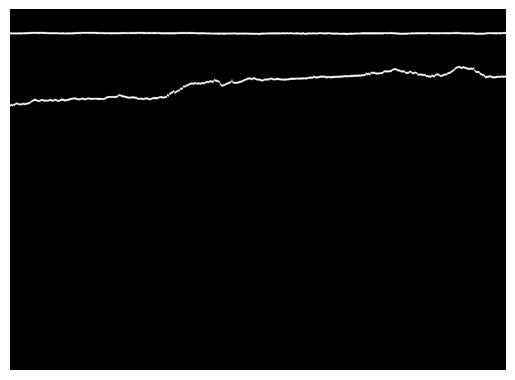

In [19]:
# plot a sample generated binary mask
radar_image = cv2.imread( './CReSIS_Binary/Data_20110329_01_011.png')
import cv2
import matplotlib.pyplot as plt
plt.imshow(radar_image)
plt.axis('off')
plt.show()